# Monsoon flood analysis using embeddings from partial inputs
This notebook contains a complete example for how to run Clay. It
combines the following three different aspects

1. Create single-chip datacubes with time series data for a location and a date range
2. Run the model with partial inputs, in this case RGB + NIR + SWIR
3. Study flood extent through the embeddings generated for that datacube

## Let's start with importing and creating constants

In [4]:
# Ensure working directory is the repo home
import os

os.chdir("..")

In [ ]:
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import pystac_client
import rasterio
import rioxarray  # noqa: F401
import stackstac
import torch
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition

from src.datamodule import ClayDataModule
from src.model_clay import CLAYModule

warnings.filterwarnings("ignore")

BAND_GROUPS = {
    "rgb": ["red", "green", "blue"],
    "rededge": ["rededge1", "rededge2", "rededge3", "nir08"],
    "nir": [
        "nir",
    ],
    "swir": ["swir16", "swir22"],
    "sar": ["vv", "vh"],
}

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

## Search for imagery over an area of interest
In this example we use a location and date range to visualize a major monsoon flood that happened in [Padidan, Pakistan in 2022](https://floodlist.com/asia/pakistan-monsoon-floods-august-2022)

In [6]:
# Point over Padidan, Pakistan
poi = 26.776567, 68.287374

# Dates of a major monsoon flood (August 20, 2022)
start = "2022-06-01"
end = "2022-09-30"

catalog = pystac_client.Client.open(STAC_API)

search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(poi[1] - 1e-5, poi[0] - 1e-5, poi[1] + 1e-5, poi[0] + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 50}},
)

items = search.get_all_items()

print(f"Found {len(items)} items")

Found 16 items


## Download the data
Get the data into a numpy array and visualize the imagery. The flood is visible in the last seven images. Note: SWIR is very helpful for flood mapping (ref: [Satellite flood detection integrating hydrogeomorphic and spectral indices](https://www.tandfonline.com/doi/full/10.1080/15481603.2022.2143670#:~:text=Methods%20used%20to%20detect%20water,Near%20Infrared%20(NIR)%20wavelengths.))

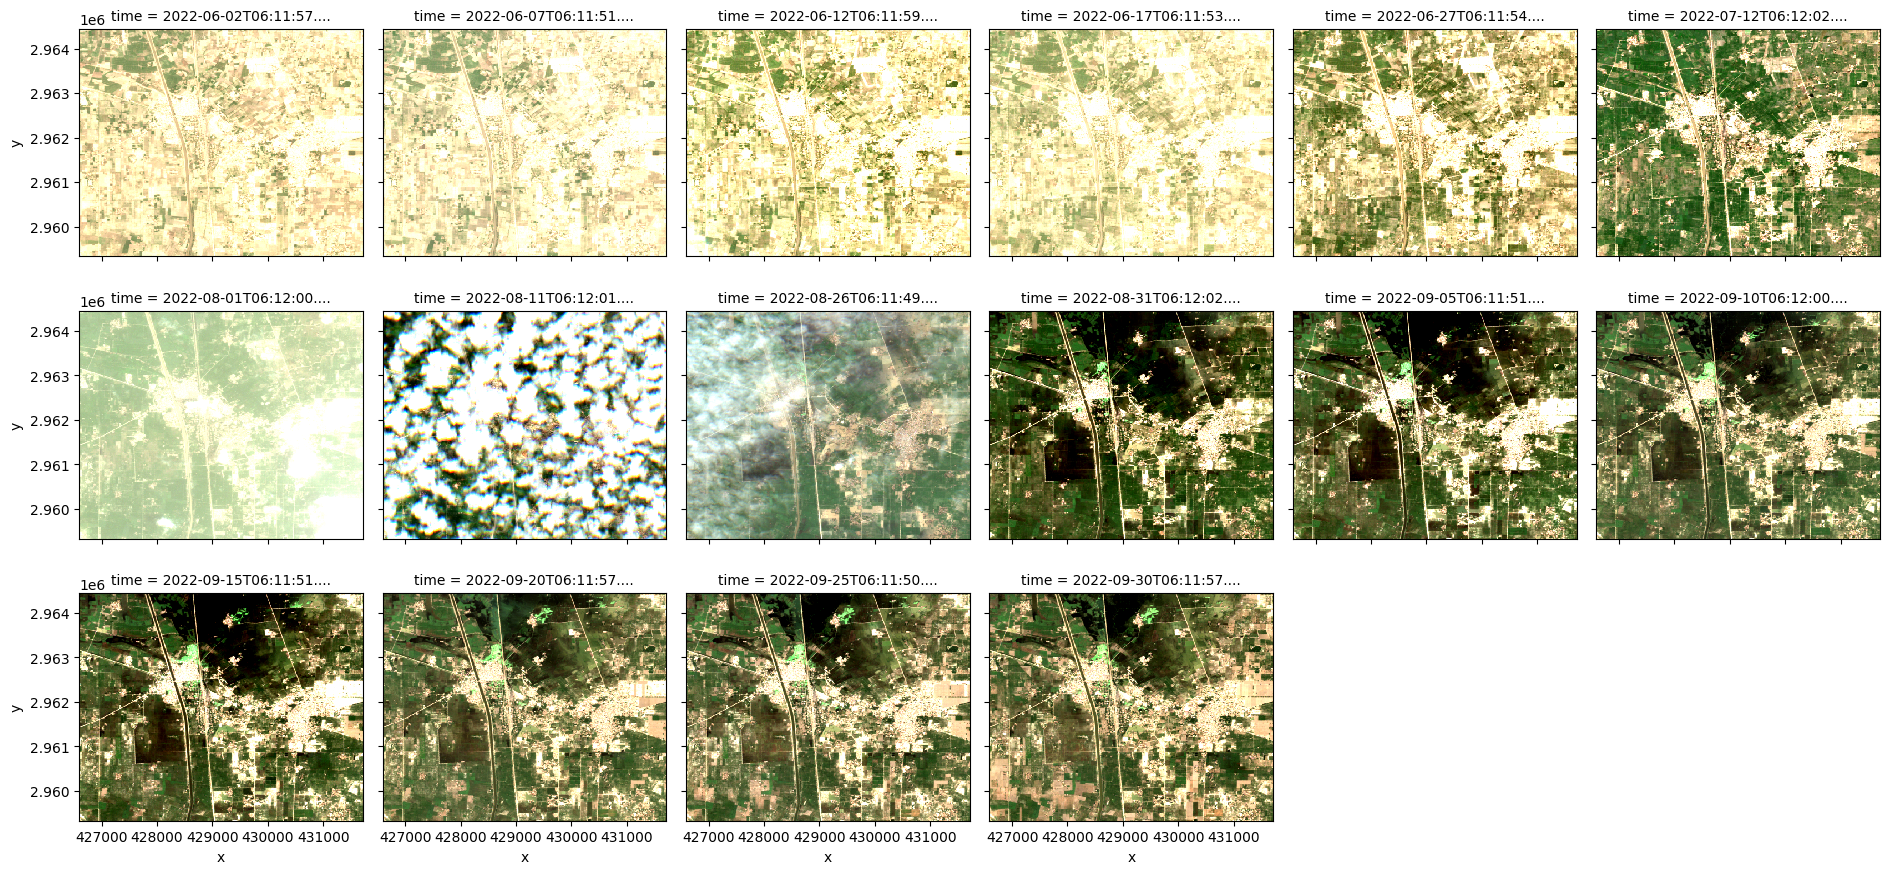

In [7]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point into the image projection
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(poi[1], poi[0])],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds of the correct size, the model
# requires 512x512 pixels at 10m resolution.
bounds = (
    coords[0] - 2560,
    coords[1] - 2560,
    coords[0] + 2560,
    coords[1] + 2560,
)

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use the
# the RGB, NIR and SWIR band groups.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS["rgb"] + BAND_GROUPS["nir"] + BAND_GROUPS["swir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()

stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

### Plot the near infrared
Notice the significant signal starting on August 26th (first image after the major flood) but appearing more strongly on the next date as August 26th was fairly cloudy.

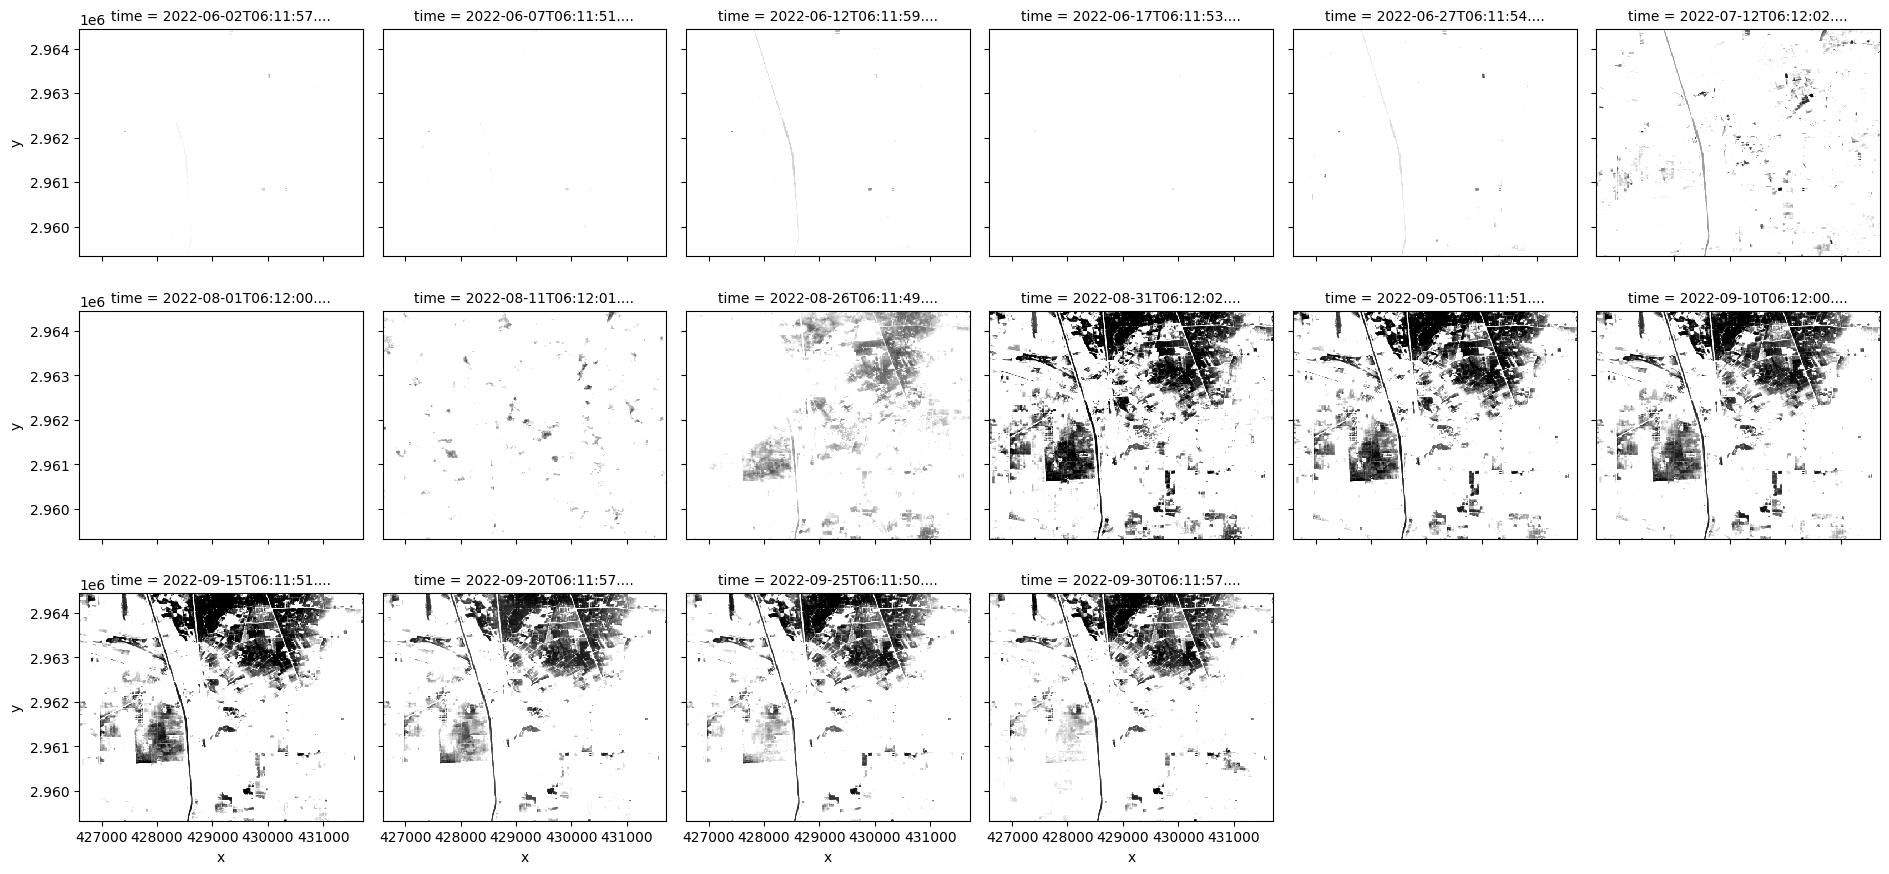

In [8]:
stack.sel(band=["nir", "nir", "nir"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

### Plot the first short-wave infrared band
Notice the same significant signal starting on August 26th (first image after the major flood), again appearing more strongly on the next date as August 26th was fairly cloudy.

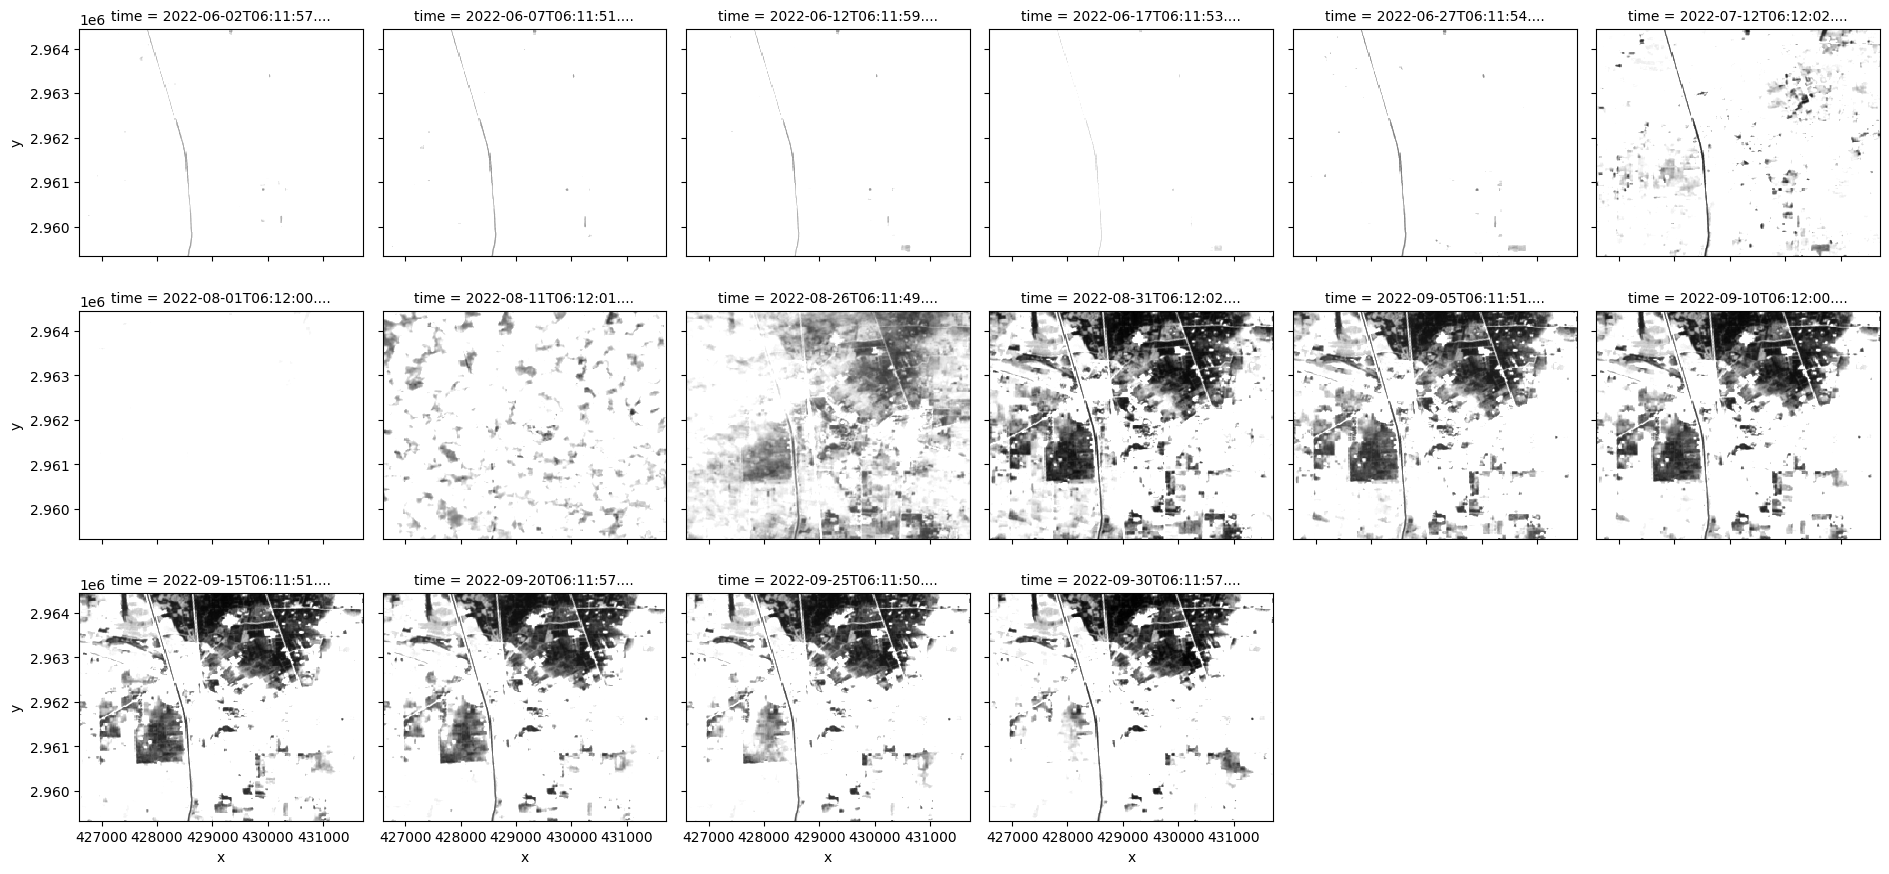

In [9]:
stack.sel(band=["swir16", "swir16", "swir16"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

### Plot the first short-wave infrared band
Notice the same significant signal starting on August 26th (first image after the major flood), again appearing more strongly on the next date as August 26th was fairly cloudy.

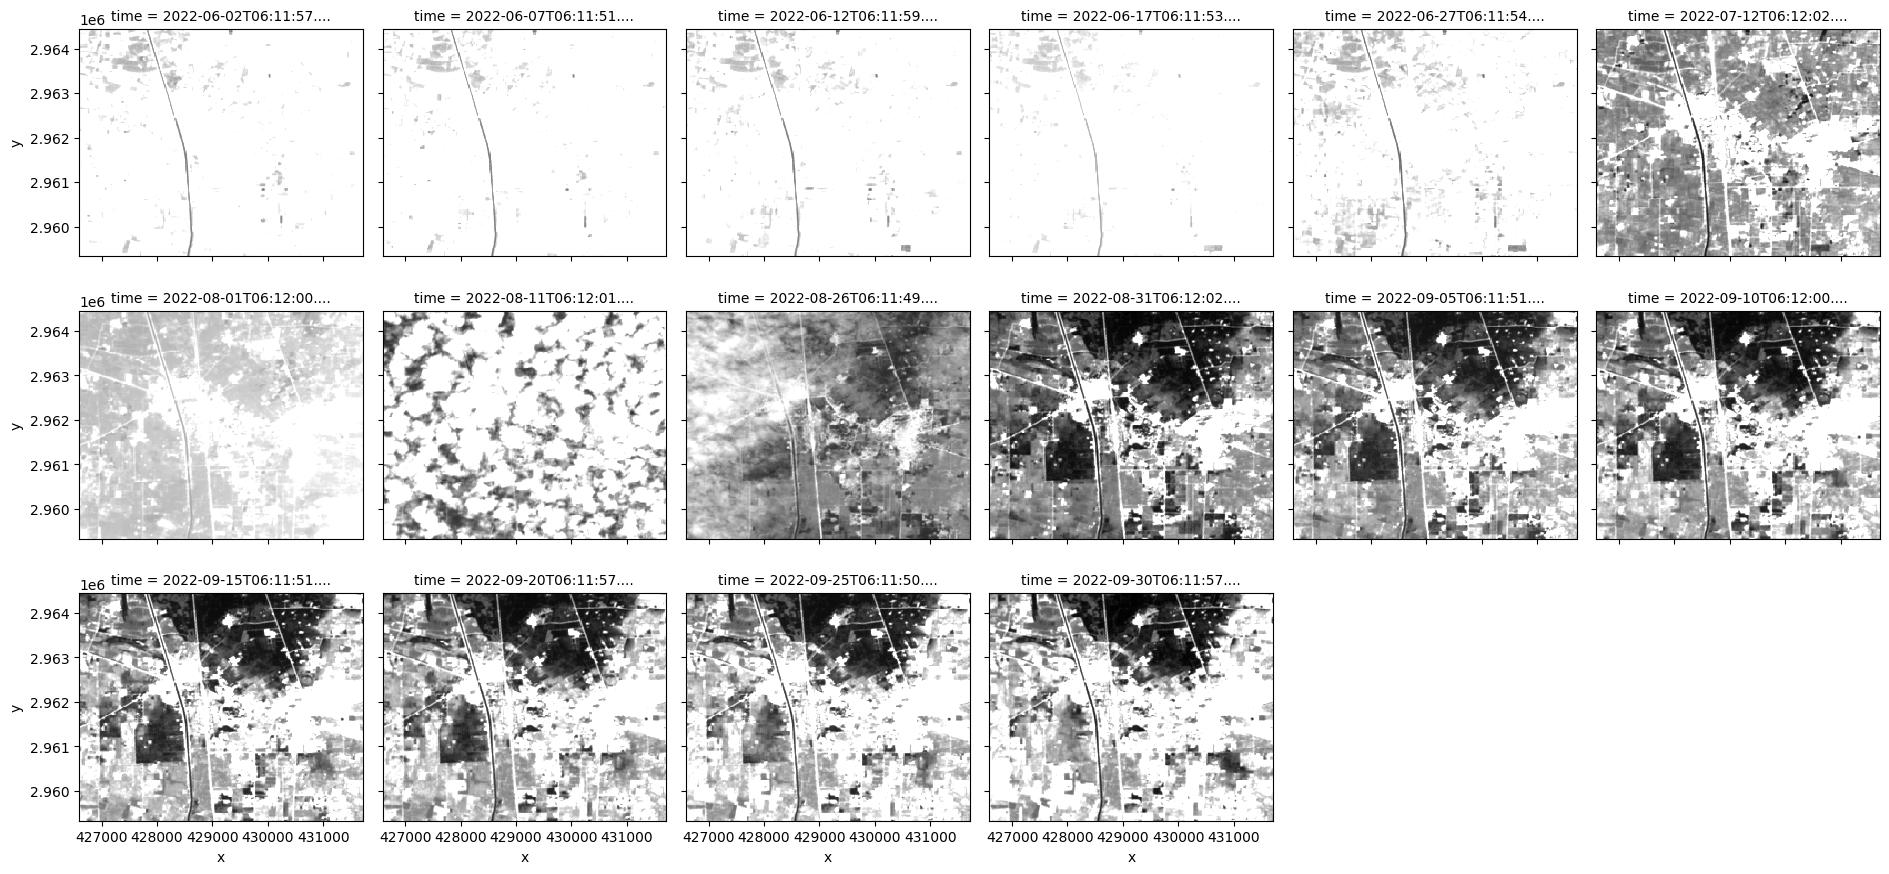

In [10]:
stack.sel(band=["swir22", "swir22", "swir22"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

## Write data to tif files
To use the mini datacube in the Clay dataloader, we need to write the
images to tif files on disk. These tif files are then used by the Clay
data loader for creating embeddings below.

In [8]:
outdir = Path("data/minicubes")
assert outdir.exists()

# Write tile to output dir
for tile in stack:
    # Grid code like MGRS-29SNB
    mgrs = str(tile.coords["grid:code"].values).split("-")[1]
    date = str(tile.time.values)[:10]

    name = "{dir}/claytile_{mgrs}_{date}.tif".format(
        dir=outdir,
        mgrs=mgrs,
        date=date.replace("-", ""),
    )
    tile.rio.to_raster(name, compress="deflate")

    with rasterio.open(name, "r+") as rst:
        rst.update_tags(date=date)

## Create embeddings
Now switch gears and load the tiles to create embeddings and analyze them. 

The model checkpoint can be loaded directly from huggingface, and the data
directory points to the directory we created in the steps above.

Note that the normalization parameters for the data module need to be 
adapted based on the band groups that were selected as partial input. The
full set of normalization parameters can be found [here](https://github.com/Clay-foundation/model/blob/main/src/datamodule.py#L108).

### Load the model and set up the data module

In [11]:
DATA_DIR = "/home/ubuntu/data/minicubes_fl_pk"
CKPT_PATH = "https://huggingface.co/made-with-clay/Clay1/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt"

# Load model
multi_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH,
    mask_ratio=0.0,
    band_groups={"rgb": (2, 1, 0), "nir": (3,), "swir": (4,5)},
    bands=6,
    strict=False,  # ignore the extra parameters in the checkpoint
)
# Set the model to evaluation mode
multi_model.eval()


# Load the datamodule, with the reduced set of
class ClayDataModuleMulti(ClayDataModule):
    MEAN = [
        1369.03,  # red
        1597.68,  # green
        1741.10,  # blue
        2893.86,  # nir
        2303.00,  # swir16
        1807.79,  # swir22
        
    ]
    STD = [
        2026.96,  # red
        2011.88,  # green
        2146.35,  # blue
        1917.12,  # nir
        1679.88,  # swir16
        1568.06,  # swir22
    ]


data_dir = Path(DATA_DIR)

dm = ClayDataModuleMulti(data_dir=str(data_dir.absolute()), batch_size=2)
dm.setup(stage="predict")
trn_dl = iter(dm.predict_dataloader())

Total number of chips: 16


### Create the embeddings for the images over the forest fire
This will loop through the images returned by the data loader
and evaluate the model for each one of the images. The raw
embeddings are reduced to mean values to simplify the data.

In [12]:
embeddings = []
ts = []
for batch in trn_dl:
    with torch.no_grad():
        # Move data from to the device of model
        batch["pixels"] = batch["pixels"].to(multi_model.device)
        # Pass just the specific band through the model
        batch["timestep"] = batch["timestep"].to(multi_model.device)
        batch["date"] = batch["date"] #.to(multi_model.device)
        batch["latlon"] = batch["latlon"].to(multi_model.device)

        # Pass pixels, latlon, timestep through the encoder to create encoded patches
        (
            unmasked_patches,
            unmasked_indices,
            masked_indices,
            masked_matrix,
        ) = multi_model.model.encoder(batch)

        embeddings.append(unmasked_patches.detach().cpu().numpy())
        ts.append(batch["date"])

embeddings = numpy.vstack(embeddings)

embeddings_mean = embeddings[:, :-2, :].mean(axis=1)

In [14]:
print(f"Average embeddings have shape {embeddings_mean.shape}")

Average embeddings have shape (16, 768)


Check the dates. Notice they are in sublists of size 2 because of the batch size.

In [15]:
ts

[['2022-06-02', '2022-06-07'],
 ['2022-06-12', '2022-06-17'],
 ['2022-06-27', '2022-07-12'],
 ['2022-08-01', '2022-08-11'],
 ['2022-08-26', '2022-08-31'],
 ['2022-09-05', '2022-09-10'],
 ['2022-09-15', '2022-09-20'],
 ['2022-09-25', '2022-09-30']]

Flatten the dates

In [16]:
tss = [t for tb in ts for t in tb]

In [17]:
tss

['2022-06-02',
 '2022-06-07',
 '2022-06-12',
 '2022-06-17',
 '2022-06-27',
 '2022-07-12',
 '2022-08-01',
 '2022-08-11',
 '2022-08-26',
 '2022-08-31',
 '2022-09-05',
 '2022-09-10',
 '2022-09-15',
 '2022-09-20',
 '2022-09-25',
 '2022-09-30']

## Analyze embeddings
Now we can make a simple analysis of the embeddings. We reduce all the
embeddings to a single number using Principle Component Analysis. Then
we can plot the principal components. The effect of the flood on the
embeddings is clearly visible. We use the following color code in the graph:

| Color | Interpretation |
|---|---|
| Green | Cloudy Images |
| Blue | Before the flood |
| Red | After the flood |

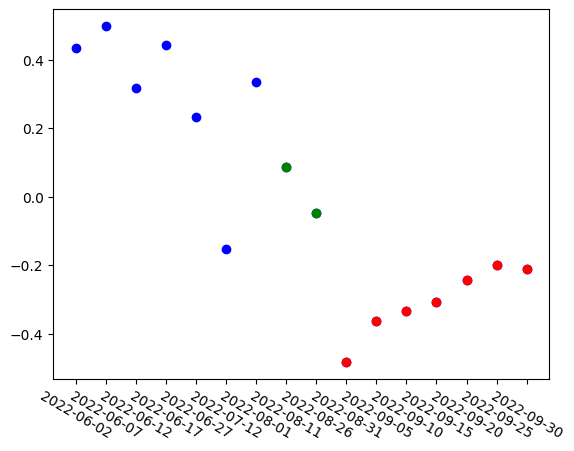

In [18]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings_mean)

plt.xticks(rotation=-30)
# All points
plt.scatter(tss, pca_result, color="blue")
#plt.scatter(stack.time, pca_result, color="blue")

# Cloudy images
plt.scatter(tss[7], pca_result[7], color="green")
plt.scatter(tss[8], pca_result[8], color="green")
#plt.scatter(stack.time[7], pca_result[7], color="green")
#plt.scatter(stack.time[8], pca_result[8], color="green")

# After flood
plt.scatter(tss[-7:], pca_result[-7:], color="red")
#plt.scatter(stack.time[-7:], pca_result[-7:], color="red")

In the plot above, each image embedding is one point. One can clearly 
distinguish the two cloudy images and the values after the flood are
consistently low.

## t-SNE example
A quick t-SNE calculation shows that the dates indeed cluster as we'd expect, with the before flood dates grouped together, and the after-flood days together.

In [21]:
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(embeddings_mean)

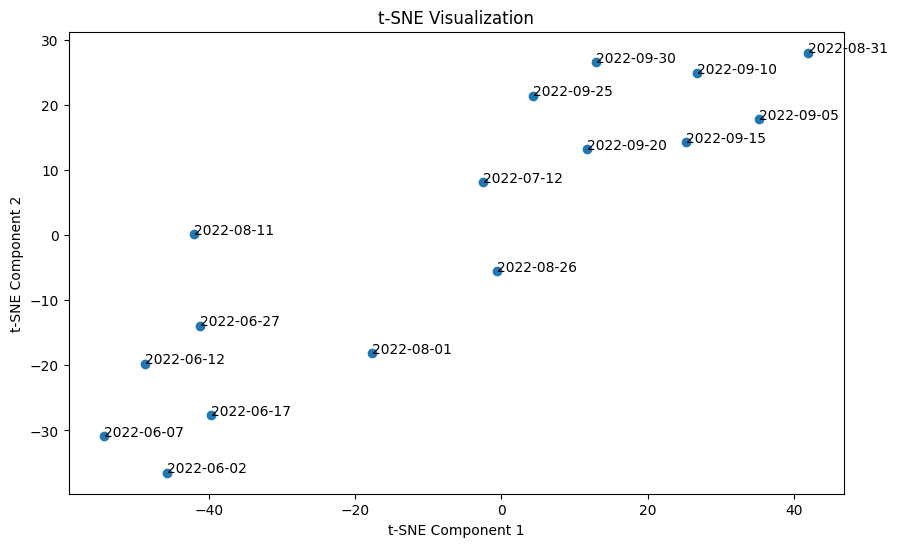

In [22]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Annotate each point with the corresponding date
for i, (x, y) in enumerate(zip(X_tsne[:, 0], X_tsne[:, 1])):
    plt.annotate(f'{tss[i]}', (x, y))
    
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()